# Hyperparameter Tuning
(by Tevfik Aytekin)

Machine learning algorithms generally have parameters which effect the performance of the algorithm. In order to get the best performance one needs to find the best parameters values. The general approach for finding the best values is to form a hyperparameter grid and try all possible combinations.

### Search for best max_depth in a decision tree

The following example shows the effect of tree depth on the performance of the model. The result shows that it is important to find the best tree depth value in order to build the best model.

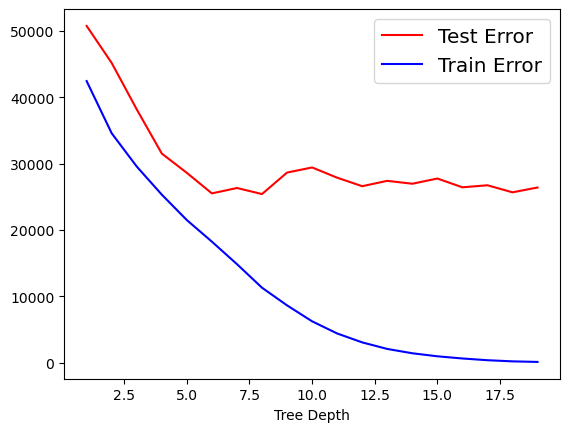

In [3]:
# run Regression Tree on SalesPrice dataset
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error


train = pd.read_csv("../datasets/house_prices/train.csv")
X = train.loc[:,'MSSubClass':'SaleCondition']
y = train.loc[:,'SalePrice']
X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

depth = list(range(1,20))
train_errors = []
test_errors = []
for i in depth:
    clf = DecisionTreeRegressor(max_depth=i)  
    clf.fit(X_train, y_train);

    y_pred = clf.predict(X_train)  
    mae = mean_absolute_error(y_train, y_pred)
    train_errors.append(mae)
   
    y_pred = clf.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    test_errors.append(mae)

fig, ax = plt.subplots()
ax.plot(depth, test_errors, 'r', label='Test Error')
ax.plot(depth, train_errors, 'b', label='Train Error')
ax.set_xlabel("Tree Depth")
legend = ax.legend(loc='upper right', fontsize='x-large')


### Search for best k in kNN

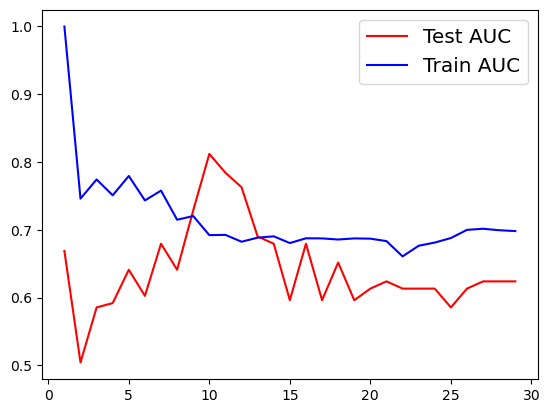

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split  
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
names = ['age', 'gender', 'cp', 'trestbps', 'chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','diagnosis']
heart = pd.read_csv(url, names=names, na_values=["?"])

X = heart.iloc[:,0:12]
y = heart.iloc[:,13]
y = y.replace([1,2,3,4],[1,1,1,1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())

neighbors = list(range(1,30))
train_errors = []
test_errors = []
for i in neighbors:
    clf = KNeighborsClassifier(n_neighbors=i)  
    clf.fit(X_train, y_train);

    y_pred = clf.predict(X_train)  
    fpr, tpr, th = roc_curve(y_train, y_pred)
    auc_score = auc(fpr, tpr)
    train_errors.append(auc_score)
   
    y_pred = clf.predict(X_test)
    fpr, tpr, th = roc_curve(y_test, y_pred)
    auc_score = auc(fpr, tpr)
    test_errors.append(auc_score)

fig, ax = plt.subplots()
ax.plot(neighbors, test_errors, 'r', label='Test AUC')
ax.plot(neighbors, train_errors, 'b', label='Train AUC')
legend = ax.legend(loc='upper right', fontsize='x-large')


In [5]:
heart.shape

(303, 14)

#### Grid Search (K-NN)

In [5]:
# specify parameters and distributions to sample from
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
from time import time

X = heart.iloc[:,0:12]
X = X.fillna(X.mean())
y = heart.iloc[:,13]
y = y.replace([1,2,3,4],[1,1,1,1])
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# Utility function to report best scores
def report(results, n_top=240): #print all results
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

k_range    = range(1,31)
param_grid = {"n_neighbors": k_range,
              "weights": ["uniform", "distance"],
             "metric": ["euclidean", "manhattan", "chebyshev", "minkowski"]}

# run grid search
clf = KNeighborsClassifier()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 4.91 seconds for 240 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.703 (std: 0.067)
Parameters: {'metric': 'manhattan', 'n_neighbors': 27, 'weights': 'uniform'}

Model with rank: 1
Mean validation score: 0.703 (std: 0.069)
Parameters: {'metric': 'manhattan', 'n_neighbors': 28, 'weights': 'distance'}

Model with rank: 1
Mean validation score: 0.703 (std: 0.067)
Parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'uniform'}

Model with rank: 4
Mean validation score: 0.700 (std: 0.064)
Parameters: {'metric': 'manhattan', 'n_neighbors': 29, 'weights': 'distance'}

Model with rank: 5
Mean validation score: 0.696 (std: 0.070)
Parameters: {'metric': 'manhattan', 'n_neighbors': 30, 'weights': 'distance'}

Model with rank: 6
Mean validation score: 0.693 (std: 0.059)
Parameters: {'metric': 'manhattan', 'n_neighbors': 26, 'weights': 'uniform'}

Model with rank: 6
Mean validation score: 0.693 (std: 0.062)
Parameters: {'metric': 'manhattan

#### Randomized Grid Search (K-NN)

From sklearn documentation:

In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.

If all parameters are presented as a list, sampling without replacement is performed. If at least one parameter is given as a distribution, sampling with replacement is used

In [6]:
# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_grid,
                                   n_iter=n_iter_search, cv=5)

start = time()
random_search.fit(X, y)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 0.45 seconds for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.683 (std: 0.055)
Parameters: {'weights': 'uniform', 'n_neighbors': 15, 'metric': 'manhattan'}

Model with rank: 2
Mean validation score: 0.680 (std: 0.066)
Parameters: {'weights': 'uniform', 'n_neighbors': 24, 'metric': 'manhattan'}

Model with rank: 3
Mean validation score: 0.673 (std: 0.041)
Parameters: {'weights': 'uniform', 'n_neighbors': 11, 'metric': 'manhattan'}

Model with rank: 4
Mean validation score: 0.673 (std: 0.077)
Parameters: {'weights': 'uniform', 'n_neighbors': 25, 'metric': 'manhattan'}

Model with rank: 5
Mean validation score: 0.667 (std: 0.057)
Parameters: {'weights': 'distance', 'n_neighbors': 18, 'metric': 'manhattan'}

Model with rank: 6
Mean validation score: 0.657 (std: 0.058)
Parameters: {'weights': 'uniform', 'n_neighbors': 4, 'metric': 'manhattan'}

Model with rank: 7
Mean validation score: 0.650 (std: 0.054)
Parameters: {'weights': 'unifo

#### Grid Search (Decision Tree)

In [7]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {"criterion": ["gini", "entropy"],
              "min_samples_split": [2, 10, 20, 25],
              "max_depth": [None, 2, 5, 10]
             }
# run grid search
clf = DecisionTreeClassifier()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='accuracy')
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


GridSearchCV took 0.51 seconds for 32 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.792 (std: 0.040)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 25}

Model with rank: 2
Mean validation score: 0.789 (std: 0.038)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 25}

Model with rank: 2
Mean validation score: 0.789 (std: 0.038)
Parameters: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 25}

Model with rank: 4
Mean validation score: 0.789 (std: 0.043)
Parameters: {'criterion': 'gini', 'max_depth': None, 'min_samples_split': 25}

Model with rank: 4
Mean validation score: 0.789 (std: 0.043)
Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_split': 25}

Model with rank: 6
Mean validation score: 0.785 (std: 0.039)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_split': 25}

Model with rank: 7
Mean validation score: 0.785 (std: 0.044)
Parameters: {'criterion': 'gini'

In [8]:
y.size

303

In [16]:
from sklearn.tree import DecisionTreeRegressor

train = pd.read_csv("../datasets/house_prices/train.csv")
X = train.loc[:,'MSSubClass':'SaleCondition']
y = train.loc[:,'SalePrice']
X = pd.get_dummies(X)

X = X.fillna(X.mean())

param_grid = {"criterion": ["squared_error", "friedman_mse", "absolute_error", "poisson"],
              "min_samples_split": [2, 10, 20, 25],
              "max_depth": [None, 2, 5, 10]
             }
# run grid search
clf = DecisionTreeRegressor()

grid_search = GridSearchCV(clf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
start = time()
grid_search.fit(X, y)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:619: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 1256, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py", line 159, in fit
    check_y_params))
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/base.py", line 430, in _validate_data
    X = check_array(X, **check_X_params)
  File "/Users/tevfikaytekin/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py", line 63, in inner_f


ValueError: could not convert string to float: 'RL'

#### Limits of Hyperparameter Tuning

With hyperparameter tuning you can find the optimum parameter value combinations <b><i>within the bounds of the features used</i></b>. You can get further improvements if you can find good features.